Tutorial 7: Data
================

Up to now, all of the image's we've created have come from light profiles. Oher than the actual light that profile emits
there is no other effects in the images of that light profile.

This contrasts real data of a strong lens, where there are lots of other effects in our strong lens imagimg (noise,
diffraction due to the telescope optics, etc.). In this example, we use **PyAutoLens** to simulate Hubble Space
Telescope (HST) imaging of a strong lens, where the strong lens image is made via a tracer. By simulate, we mean that this
image will contain these effects that are present in real data.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Initial Setup__

We'll need a 2D grid to make the strong lens image we'll ultimately simulate as if it was observed with HST.

In [2]:
grid = al.Grid2D.uniform(shape_native=(100, 100), pixel_scales=0.1)

Now, lets setup our lens galaxy, source galaxy and tracer.

In [3]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0), einstein_radius=1.6, elliptical_comps=(0.17647, 0.0)
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllSersic(
        centre=(0.1, 0.1),
        elliptical_comps=(0.0, 0.111111),
        intensity=1.0,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

Lets look at the tracer's image; which is the image we'll be simulating.

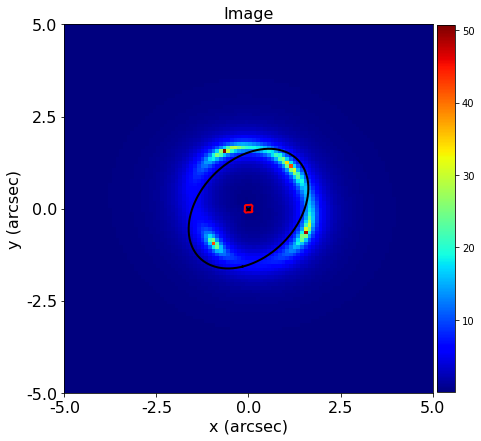

In [4]:
tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.figures_2d(image=True)

__Simulations__

To simulate an image, we need to model how the light is diffracted as it enters the telescope's optics. 

We do this using a two dimensional convolution, where a blurring kernel is used to mimic the effect of distraction. In
Astronomy, the kernel representing blurring in a telescope is called the 'Point-Spread Function' (PSF) and it is 
represented using a `Kernel2D` object, which in this example is a 2D Gaussian.

In [5]:
psf = al.Kernel2D.from_gaussian(
    shape_native=(11, 11), sigma=0.1, pixel_scales=grid.pixel_scales
)

The simulation does not use tracer's image plotted above. Instead, we use a slightly different image which is padded 
with zeros around its edge, based on the shape of the PSF that we will convolve the image with. This ensures 
edge-effects do not degrade our simulation`s PSF convolution.

In [6]:
normal_image = tracer.image_2d_from_grid(grid=grid)
padded_image = tracer.padded_image_2d_from_grid_and_psf_shape(
    grid=grid, psf_shape_2d=psf.shape_native
)

print(normal_image.shape_native)
print(padded_image.shape_native)

(100, 100)
(110, 110)


To simulate imaging data we create a `SimulatorImaging` object, which represents all of the effects that occur when
imaging data is accquired in a telescope, including:

 1) Diffraction due to the telescope optics: this uses the Point Spread Function defined above.
 
 2) The Background Sky: this is background light from the Universe that is observed in addition to the strong lens's 
 light (the image that is returned is has this background sky subtracted, so it simply acts as a source of noise).
 
 3) Poisson noise: Due to the background sky, lens galaxy and source galaxy Poisson photon counts.
 
We pass the tracer and grid to the simulator to create the image of the strong lens and add the above effects to it.

In [7]:
simulator = al.SimulatorImaging(
    exposure_time=300.0, psf=psf, background_sky_level=0.1, add_poisson_noise=True
)

imaging = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

By plotting the image, we can see it has been blurred due to the telescope optics and that noise has been added.

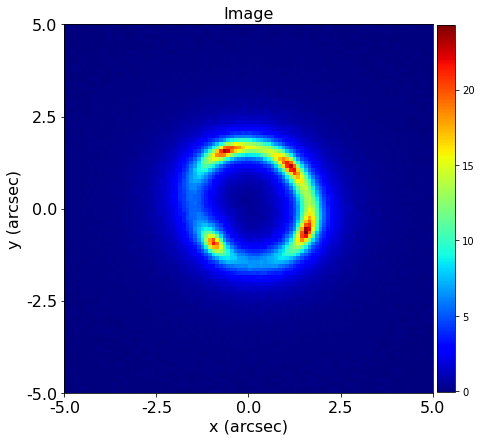

In [8]:
imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.figures_2d(image=True)

__Output__

We'll finally output these files to `.fits` files, which is the data storage format used by Astronomers to store
images. Pretty much all data from telescope like HST comes in `.fits` format, and **PyAutoLens** has built-in tools 
for manipulating `.fits` files.

The `dataset_path` specifies where the data is output, this time in the directory 
`autolens_workspace/dataset/imaging/no_lens_light/howtolens/`, which contains many example images of strong lens 
distributed with the`autolens_workspace`.

In [9]:
dataset_path = path.join("dataset", "imaging", "no_lens_light", "howtolens")
print("Dataset Path: ", dataset_path)

Dataset Path:  dataset/imaging/no_lens_light/howtolens


Finally, output our simulated data to hard-disk. In the next tutorial we'll load our simulated imaging data from 
these `.fits` files and begin to analyse them!

In [10]:
imaging.output_to_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    overwrite=True,
)

Finish.